Agrim Gupta
<br>
<br>


# Netflix Analytics - Movie Recommendation through Correlations
<br>

Hey Netflix! let's start exposing some secrets.

This analysis has been done to understand Netflix's recommendation model. Netflix's original dataset has been used.  4 thousand titles and 0.4 million users' data has been used. 


## Table of Content:

* Objective

* Data manipulation
    -  Data loading
    -  Data viewing
    -  Data cleaning
    -  Data slicing
    -  Data mapping
    
* Recommendation models
    -  Recommend with Collaborative Filtering (*Edit on 2017/11/07*)
    -  Recommend with Pearsons' R correlation

# Objective
<br>
Learn from data and recommend best TV shows to users, based on self & others behaviour
<br>

# Data manipulation

## Data loading

Each data file (there are 4 of them) contains below columns:

* Movie ID (as first line of each new movie record / file)
* Customer ID
* Rating (1 to 5)
* Date they gave the ratings

There is another file contains the mapping of Movie ID to the movie background like name, year of release, etc

Let's import the library we needed before we get started:

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

Next let's load first data file and get a feeling of how huge the dataset is:

In [2]:
# Skip date
df1 = pd.read_csv('../input/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

# Important typecasting
df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
#print(df1.iloc[::5000000, :])
print(df1.head())

Dataset 1 shape: (24058263, 2)
-Dataset examples-
   Cust_Id  Rating
0       1:     NaN
1  1488844     3.0
2   822109     5.0
3   885013     4.0
4    30878     4.0


Let's try to load the 3 remaining dataset as well:

In [3]:
#df2 = pd.read_csv('../input/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('../input/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('../input/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


#df2['Rating'] = df2['Rating'].astype(float)
#df3['Rating'] = df3['Rating'].astype(float)
#df4['Rating'] = df4['Rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

![](http://)![](http://)Combining these datasets:

In [4]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


## Data viewing

[](http://)First look of data distribution:-

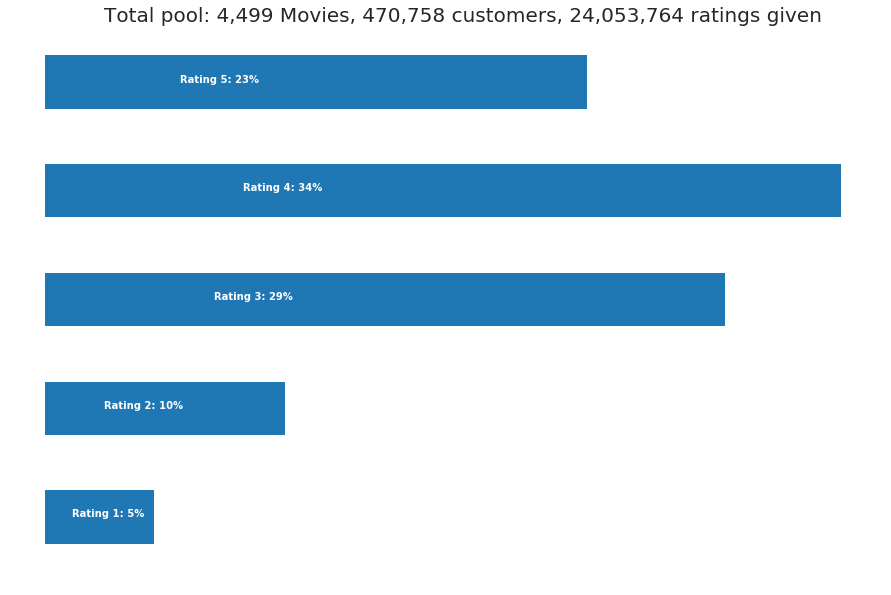

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Making the Movie ID column more efficient

In [11]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [12]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Data slicing

Reducing volume of data and making it more meaningful

*Eliminating movies with few reviews
*Eliminating users who rarely give ratings

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Implementation:-

In [13]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0


Trimming down our data, whats the difference in data size?

In [14]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (13528427, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
5109       785314     1.0         8
8889698    332300     3.0      1770
17751978   629874     4.0      3391


Pivoting the data set and putting it into a giant matrix - we need it for our recommendation system:

In [15]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)


(95325, 900)


## Data mapping

Loading Mapping file

In [16]:
df_title = pd.read_csv('../input/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# Recommendation models

Cleaning complete.

## Recommend with Filtering

Evaluting performance of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), with first 0.1 Million rows (for faster process)

In [17]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/opt/conda/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/opt/conda/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9871
MAE:  0.8117
------------
Fold 2
RMSE: 0.9830
MAE:  0.8021
------------
Fold 3
RMSE: 0.9869
MAE:  0.8010
------------
------------
Mean RMSE: 0.9857
Mean MAE : 0.8049
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9871039831833791,
                             0.9830108001091649,
                             0.9868908793074238],
                            'mae': [0.8116807641081132,
                             0.802147210945182,
                             0.8009528349391196]})

Below is what user 783514 liked in the past:

In [18]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


Movie_Id
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443                             Like Water for Chocolate
2452        Lord of the Rings: The Fellowship of the Ring
2465 

Predicting which movies user 785314 would love to watch:

In [19]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

/opt/conda/lib/python3.6/site-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


        Year      ...       Estimate_Score
2101  1994.0      ...             4.980016
3045  1990.0      ...             4.965393
2056  2001.0      ...             4.936403
2171  1991.0      ...             4.921201
328   1999.0      ...             4.802790
3149  2000.0      ...             4.802574
3443  2004.0      ...             4.792867
1727  1987.0      ...             4.782271
3520  2000.0      ...             4.781964
2113  2002.0      ...             4.769425

[10 rows x 3 columns]


## Recommend with Linear correlations

Using Pearsons' R correlation to measure  linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [20]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

A recommendation for you if you like 'What the #$*! Do We Know!?' title on Netflix. Here like implies having given a thumbs up rating.

In [21]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
PearsonR                                      Name  count      mean
                                                                   
1.000000                What the #$*! Do We Know!?  14910  3.189805
0.326285                          The 10th Kingdom   4532  3.669903
0.324225              Star Trek: Voyager: Season 5   4175  4.111377
0.316818                                  Together   3958  3.889843
0.312717      Star Trek: Deep Space Nine: Season 5   4373  4.160759
0.309444           To Gillian on her 37th Birthday   4261  3.102793
0.289334              Murder on the Orient Express   4785  3.743783
0.288829        Nausicaa of the Valley of the Wind   6674  4.189542
0.288389  Star Trek: The Next Generation: Season 5   8978  4.247494
0.286320         The Life & Death of Peter Sellers   4702  3.099957


X2: X-Men United:

In [22]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
PearsonR                      Name   count      mean
                                                    
1.000000          X2: X-Men United   98720  3.932202
0.342535             Batman Begins   54922  4.236699
0.313025  Mortal Kombat: The Movie    7633  3.165466
0.311354      The Matrix: Reloaded  106807  3.514704
0.303351    Todd McFarlane's Spawn    4684  3.612511
0.295555   The Matrix: Revolutions   60415  3.517040
0.295549                Species II    7526  2.781424
0.294434                 Daredevil   62628  2.979642
0.293918      Smallville: Season 1   10082  4.169609
0.293820            Blade: Trinity   42727  3.548974
